In [1]:
suppressPackageStartupMessages({
    source('../../R/libs.R')
    source('../../R/utils.R')
})

In [2]:
tag = "-pub"
tag = paste(tag,format(Sys.time(), "-%Y-%m-%d-%H"), sep = '')
experiment_name = 'pbmcs'
model_name="dincta"
data_path = paste('../../data/',experiment_name,sep = '')
experiment_name = paste(experiment_name, tag, sep = '')
output_path = path_join('../../outputs',experiment_name,model_name)
if(!dir.exists(output_path)){
    makedirs(output_path)
}

# Preprocessing

Load data 

In [3]:
exprs_raw <- list(
    path_join(data_path,'fiveprime_raw.rds'),
    path_join(data_path,'threepv2_raw.rds'),
    path_join(data_path,'threepv1_raw.rds')
) %>% 
    lapply(readRDS) %>% 
    purrr::reduce(Matrix::cbind2)

meta_data <- fread(path_join(data_path,'metadata.csv'))


In [4]:
head(meta_data)

cell_id,donor,nUMI,nGene,percent_mito,cell_type,res_0.80,cell_subtype
<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<chr>
threepfresh_AAACCTGAGCATCATC,threepfresh,2394,871,0.03842941,bcells,3,bnaive
threepfresh_AAACCTGAGCTAACTC,threepfresh,1694,806,0.05726092,mono,5,mono14
threepfresh_AAACCTGAGCTAGTGG,threepfresh,4520,1316,0.01946903,tcells,2,cd4mem
threepfresh_AAACCTGCACATTAGC,threepfresh,2788,898,0.01398852,tcells,1,cd4naive
threepfresh_AAACCTGCACTGTTAG,threepfresh,4667,1526,0.03621170,mono,0,mono14
threepfresh_AAACCTGCATAGTAAG,threepfresh,4440,1495,0.03806306,mono,0,mono14


In [5]:
# The source of batch here is technology: 

# - fivePrime: 10X 5-prime
# - threepfresh: 10X 3-prime V2
# - threepv1: 10X 3-prime V1

In [6]:
table(meta_data$donor)


  fivePrime threepfresh    threepv1 
       7697        8380        4809 

In [7]:
# Normalize data (log CP10K)

In [8]:
genes_use <- which(Matrix::rowSums(exprs_raw[, meta_data$cell_id] != 0) >= 10)
genes_use <- genes_use[which(!grepl('^MT-', names(genes_use)))]
exprs_norm <- exprs_raw[genes_use, meta_data$cell_id] %>% 
    normalizeData(method = 'log', 1e4)

In [9]:
# Select variable genes

In [10]:
vargenes_df <- singlecellmethods::findVariableGenes(exprs_norm, meta_data$donor)
var_genes <- unique(data.table(vargenes_df)[, head(.SD[order(-gene_dispersion_scaled)], 1000), by = group][, symbol])

In [11]:
length(var_genes)


[1] 2122

In [12]:
# PCA embedding

In [13]:
pca_res <- exprs_norm[var_genes, ] %>% 
    singlecellmethods::scaleData() %>% 
    irlba::irlba(20)
pca_embedding <- pca_res$v %*% diag(pca_res$d)        

In [14]:
# UMAP embedding

In [15]:
pca_umap <- do_umap(pca_embedding)

In [16]:
saveRDS(exprs_raw, path_join(output_path,'exprs_raw.rds'))
saveRDS(meta_data,path_join(output_path,'meta_data.rds' ))
saveRDS(pca_embedding,path_join(output_path,'pca_embedding.rds'))
saveRDS(pca_umap,path_join(output_path,'pca_umap.rds'))

In [17]:
pca_embedding = readRDS(path_join(output_path,'pca_embedding.rds'))
meta_data = readRDS(path_join(output_path,'meta_data.rds' ))
pca_umap = readRDS(path_join(output_path,'pca_umap.rds' ))


In [18]:
N = length(meta_data[['donor']])
data = meta_data[['donor']]
unique(data)
cell_type = meta_data[['cell_type']]
cell_select = rep(T,N )
table(cell_type[data=="fivePrime"])
and<-function(a,b){
    res = a
    for(i in 1:length(a)){
        res[i] = a[i]&b[i]
    }
    return(res)
}
cell_select[and(data=="fivePrime",cell_type=="mono")] =F
cell_select[and(data=="threepv1",cell_type=="tcells")] =F
cell_select[and(data=="threepfresh",cell_type=="bcells")] =F
dim(meta_data[cell_select])
table(cell_select)
meta_data = meta_data[cell_select]
dim(pca_embedding)
dim(pca_umap)
pca_embedding = pca_embedding[cell_select,]
pca_umap = pca_umap[cell_select,]
dim(pca_embedding)
dim(pca_umap)

[1] "threepfresh" "threepv1"    "fivePrime"


       bcells     dc     mk   mono     nk tcells 
    76   1191    107     36   2600    310   3377 

[1] 14460     8

cell_select
FALSE  TRUE 
 6426 14460 

[1] 20886    20

[1] 20886     2

[1] 14460    20

[1] 14460     2

In [19]:
data = meta_data[['donor']]
cell_type = meta_data[['cell_type']]
table(cell_type)
table(cell_type[data=="fivePrime"])
table(cell_type[data=="threepfresh"])
table(cell_type[data=="threepv1"])

cell_type
       bcells     dc     mk   mono     nk tcells 
   195   1777    398     99   3242    922   7827 


       bcells     dc     mk     nk tcells 
    76   1191    107     36    310   3377 


           dc     mk   mono     nk tcells 
    86    222     43   2042    315   4450 


       bcells     dc     mk   mono     nk 
    33    586     69     20   1200    297 

In [20]:
#parameters 
dataset = 'donor'
cell_type = 'cell_type'
do_pca = FALSE
sigma.entropy = 0.1
sigma.cell_type = 0.1
theta.batch=2
mu=0.01
verbose=T
plot_convergence = T
R.cross.entropy.type ='bc'
return_object = T
max.iter.dincta=20 
frequency.update.Phi_C = rep(10,5,3,2)
alphas=rep(0.5,max.iter.dincta)
keep.known.cell_type=FALSE
refine.Phi_C = FALSE
max.times.refine.Phi_C = 3
select.refine.fraction = 0.2
epsilon.cell_type.changed = 1e-2
epsilon.cells.type.changed_frequence = 1e-7
n.cell_type.residual = 16
k_cluster.n.cells.outer.threshold =6
k_cluster.n.cells.inner.threshold =2
new.cell_type.prob.threshold=0.8
cell_type.sample.fraction=0.9
new.cell_type.main.fraction = 0.9
cell_type.eigval.threshold=0.98
new.cell_type.min.cells=10
cell_type.min.cells=10
centroid.cor.threshold = 0.6




In [21]:
fake_cell_type = mask_celltype(meta_data,"cell_type",mask_var_use='donor', mask_var_values_use = c('fivePrime'))
fake_cell_type[meta_data[["cell_type"]] == "mono"] = "unknown"
# fake_cell_type[meta_data[["cell_type"]] == "mk"] = "unknown"
# fake_cell_type[meta_data[["cell_type"]] == "bcells"] = "unknown"

meta_data[["fake_cell_type"]] = fake_cell_type

table(fake_cell_type)
table(meta_data[["cell_type"]])

fake_cell_type
         bcells      dc      mk      nk  tcells unknown 
    119     586     291      63     612    4450    8339 


       bcells     dc     mk   mono     nk tcells 
   195   1777    398     99   3242    922   7827 

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Dincta 1/20

Dincta 2/20

Dincta 3/20

Dincta 4/20

Dincta 5/20

Dincta 6/20

Dincta 7/20

Dincta converged after 7 iterations



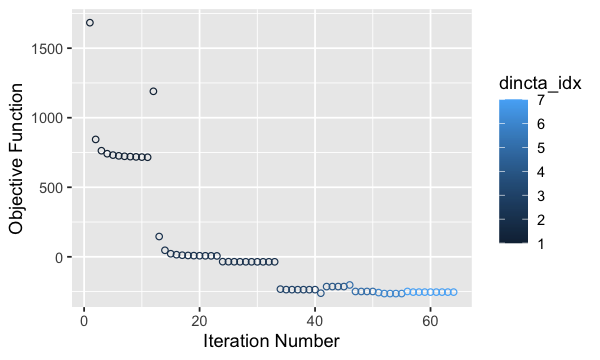

In [22]:
fig.size(3, 5)

R.cross.entropy.type = 'bc'
cell_type = "fake_cell_type"
dincta_partial_unknown_res <- dincta::DinctaMatrix(pca_embedding, meta_data, dataset, cell_type, do_pca = do_pca,
                                           theta.batch=theta.batch, mu=mu,
                                           sigma.entropy = sigma.entropy,
                                           sigma.cell_type = sigma.cell_type,
                                           verbose=verbose, plot_convergence = plot_convergence,
                                           R.cross.entropy.type = R.cross.entropy.type,
                                           return_object = return_object, alphas=alphas,
                                              refine.Phi_C = refine.Phi_C,
                                           frequency.update.Phi_C = frequency.update.Phi_C,
                                              n.cell_type.residual =n.cell_type.residual,
                                                          k_cluster.n.cells.outer.threshold =k_cluster.n.cells.outer.threshold,
k_cluster.n.cells.inner.threshold =k_cluster.n.cells.inner.threshold,
new.cell_type.prob.threshold=new.cell_type.prob.threshold,
cell_type.sample.fraction=cell_type.sample.fraction,
new.cell_type.main.fraction = new.cell_type.main.fraction,
cell_type.eigval.threshold=cell_type.eigval.threshold,
                                                      cell_type.min.cells=cell_type.min.cells,
                                              new.cell_type.min.cells=new.cell_type.min.cells,
                                                   centroid.cor.threshold =centroid.cor.threshold ,
                                           max.iter.dincta = max.iter.dincta,
                                              select.refine.fraction = select.refine.fraction ,
                                                   keep.known.cell_type = keep.known.cell_type,
    epsilon.cell_type.changed = epsilon.cell_type.changed)
dincta_partial_unknown_obj = dincta_partial_unknown_res[[1]]
dincta_partial_unknown_meta_data = dincta_partial_unknown_res[[2]]

In [23]:
fake_cell_type = rep("unknown", length(meta_data[["cell_type"]]))
meta_data[["fake_cell_type"]] = fake_cell_type

table(fake_cell_type)

fake_cell_type
unknown 
  14460 

Dincta 1/20

Dincta 2/20

Dincta 3/20

Dincta 4/20

Dincta 5/20

Dincta 6/20

Dincta 7/20

Dincta 8/20

Dincta converged after 8 iterations



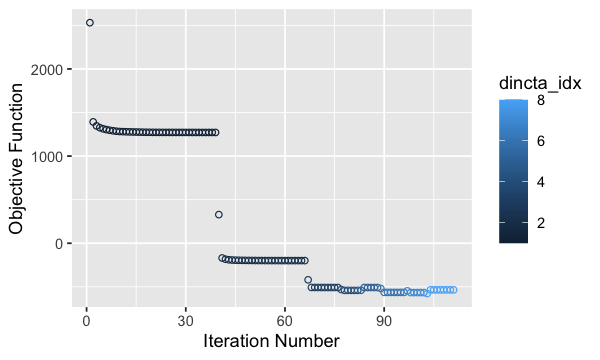

In [24]:
fig.size(3, 5)
# name dincta_[full|partial]_[bc|b]_obj
frequency.update.Phi_C = rep(100,100,10)
min.iter.dincta=3
R.cross.entropy.type = 'bc'
cell_type = "fake_cell_type"
dincta_whole_unknown_res <- dincta::DinctaMatrix(pca_embedding, meta_data, dataset, cell_type, do_pca = do_pca,
                                           theta.batch=theta.batch, mu=mu,
                                           sigma.entropy = sigma.entropy,
                                           sigma.cell_type = sigma.cell_type,
                                           verbose=verbose, plot_convergence = plot_convergence,
                                           R.cross.entropy.type = R.cross.entropy.type,
                                           return_object = return_object, alphas=alphas,
                                              refine.Phi_C = refine.Phi_C,
                                             
                                           frequency.update.Phi_C = frequency.update.Phi_C,
                                              n.cell_type.residual =n.cell_type.residual,
                                                          k_cluster.n.cells.outer.threshold =k_cluster.n.cells.outer.threshold,
k_cluster.n.cells.inner.threshold =k_cluster.n.cells.inner.threshold,
new.cell_type.prob.threshold=new.cell_type.prob.threshold,
cell_type.sample.fraction=cell_type.sample.fraction,
new.cell_type.main.fraction = new.cell_type.main.fraction,
cell_type.eigval.threshold=cell_type.eigval.threshold,
                                                      cell_type.min.cells=cell_type.min.cells,
                                              new.cell_type.min.cells=new.cell_type.min.cells,
                                                  centroid.cor.threshold =centroid.cor.threshold ,
                                                 min.iter.dincta=min.iter.dincta,
                                           max.iter.dincta = max.iter.dincta,
                                             select.refine.fraction = select.refine.fraction ,
                                                   keep.known.cell_type = keep.known.cell_type,
    epsilon.cell_type.changed = epsilon.cell_type.changed)
dincta_whole_unknown_obj = dincta_whole_unknown_res[[1]]
dincta_whole_unknown_meta_data = dincta_whole_unknown_res[[2]]

# Harmony

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony converged after 5 iterations



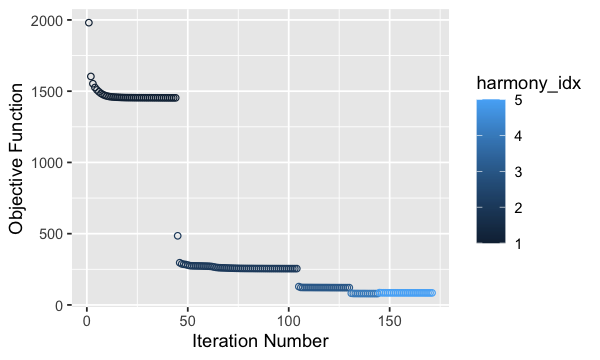

In [25]:
fig.size(3, 5)
harmony_obj <- HarmonyMatrix(
    pca_embedding, 
    meta_data,
    dataset, 
    theta=theta.batch, 
    mu=mu,
    do_pca=do_pca, 
    plot_convergence=plot_convergence,
    return_object=return_object,
    max.iter.harmony=max.iter.dincta,
    verbose=verbose,
    sigma=sigma.entropy
)
harmony_embedding = get_embedding(harmony_obj, pca_embedding)
harmony_umap <- do_umap(harmony_embedding)

# Dincta

Dincta 1/20

Dincta 2/20

Dincta 3/20

Dincta 4/20

Dincta converged after 4 iterations



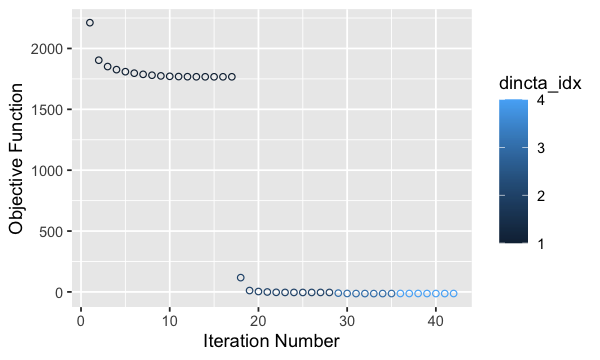

In [26]:
fig.size(3, 5)
# name dincta_[full|partial]_[bc|b]_obj
R.cross.entropy.type = 'bc'
cell_type = "cell_type"
dincta_whole_known_res <- dincta::DinctaMatrix(pca_embedding, meta_data, dataset, cell_type, do_pca = do_pca,
                                           theta.batch=theta.batch, mu=mu,
                                           sigma.entropy = sigma.entropy,
                                           sigma.cell_type = sigma.cell_type,
                                           verbose=verbose, plot_convergence = plot_convergence,
                                           R.cross.entropy.type = R.cross.entropy.type,
                                           return_object = return_object, alphas=alphas,
                                           frequency.update.Phi_C = frequency.update.Phi_C,
                                           max.iter.dincta = max.iter.dincta)
dincta_whole_known_obj = dincta_whole_known_res[[1]]
dincta_whole_known_meta_data = dincta_whole_known_res[[2]]

dincta_whole_known_embedding= get_embedding(dincta_whole_known_obj, pca_embedding)
dincta_whole_known_umap <- do_umap(dincta_whole_known_embedding)

In [27]:
dincta_partial_unknown_embedding= get_embedding(dincta_partial_unknown_obj, pca_embedding)
dincta_partial_unknown_umap <- do_umap(dincta_partial_unknown_embedding)

In [28]:
dincta_whole_unknown_embedding= get_embedding(dincta_whole_unknown_obj, pca_embedding)
dincta_whole_unknown_umap <- do_umap(dincta_whole_unknown_embedding)

In [29]:
table(as.character(dincta_partial_unknown_meta_data[["dataset"]]))
table(as.character(dincta_partial_unknown_meta_data[["cell_type"]]))
table(as.character(dincta_partial_unknown_meta_data[["fake_cell_type"]]))
table(as.character(dincta_partial_unknown_meta_data[["cell_type_predict"]]))

table(as.character(dincta_whole_unknown_meta_data[["cell_type_predict"]]))

< table of extent 0 >


       bcells     dc     mk   mono     nk tcells 
   195   1777    398     99   3242    922   7827 


         bcells      dc      mk      nk  tcells unknown 
    119     586     291      63     612    4450    8339 


             V1          bcells              dc              mk new_cell_type_1 
            207            1771             405              88             527 
new_cell_type_2              nk          tcells 
           2719             935            7808 


new_cell_type_1 new_cell_type_2 new_cell_type_3 new_cell_type_4 new_cell_type_5 
            157             327             102            1781            1786 
new_cell_type_6 new_cell_type_7 new_cell_type_8 
           4469            2495            3343 

In [30]:
lisi_res <- rbind(
    lisi::compute_lisi(dincta_whole_known_embedding, meta_data, c('donor', 'cell_type')) %>% 
        dplyr::mutate(type = 'dincta_whole_known'),
    lisi::compute_lisi(dincta_partial_unknown_embedding, meta_data, c('donor', 'cell_type')) %>% 
        dplyr::mutate(type = 'dincta_partial_unknown'),
    lisi::compute_lisi(dincta_whole_unknown_embedding, meta_data, c('donor', 'cell_type')) %>% 
        dplyr::mutate(type = 'dincta_whole_unknown'),
    lisi::compute_lisi(harmony_embedding, meta_data, c('donor', 'cell_type')) %>% 
        dplyr::mutate(type = 'harmony'),
    lisi::compute_lisi(pca_embedding, meta_data, c('donor', 'cell_type')) %>% 
        dplyr::mutate(type = 'pca')
) %>% 
    tidyr::gather(key, val, cell_type, donor)

In [31]:
saveRDS(lisi_res,path_join(output_path,'lisi_res.rds'))

In [32]:
head(lisi_res)

,type,key,val
,<chr>,<chr>,<dbl>
1,dincta_whole_known,cell_type,1.000000
2,dincta_whole_known,cell_type,1.000000
3,dincta_whole_known,cell_type,1.000000
4,dincta_whole_known,cell_type,1.000000
5,dincta_whole_known,cell_type,1.000000
6,dincta_whole_known,cell_type,1.011727


In [33]:
options(digits = 5,continue = T)
lisi_res_table = round(lisi_mean_std(lisi_res),3)
lisi_res_table

,cell_type mean,cell_type std,donor mean,donor std
dincta_whole_known,1.015,0.105,1.636,0.389
dincta_partial_unknown,1.017,0.104,1.664,0.376
dincta_whole_unknown,1.034,0.147,1.643,0.353
harmony,1.041,0.154,1.689,0.349
pca,1.017,0.112,1.015,0.110


In [34]:
type =lisi_res$type
type_new=type
type_new[type =="dincta_whole_known"] ="dincta_w_k"
type_new[type =="dincta_partial_unknown"] ="dincta_p_u"
type_new[type =="dincta_whole_unknown"] ="dincta_w_u"
lisi_res$type_new = type_new

Warning message:
“Removed 92 rows containing non-finite values (stat_density).”
Warning message:
“Removed 3699 rows containing non-finite values (stat_density).”
Warning message:
“Removed 92 rows containing non-finite values (stat_density).”
Warning message:
“Removed 3699 rows containing non-finite values (stat_density).”
Warning message:
“Removed 92 rows containing non-finite values (stat_density).”
Warning message:
“Removed 3699 rows containing non-finite values (stat_density).”


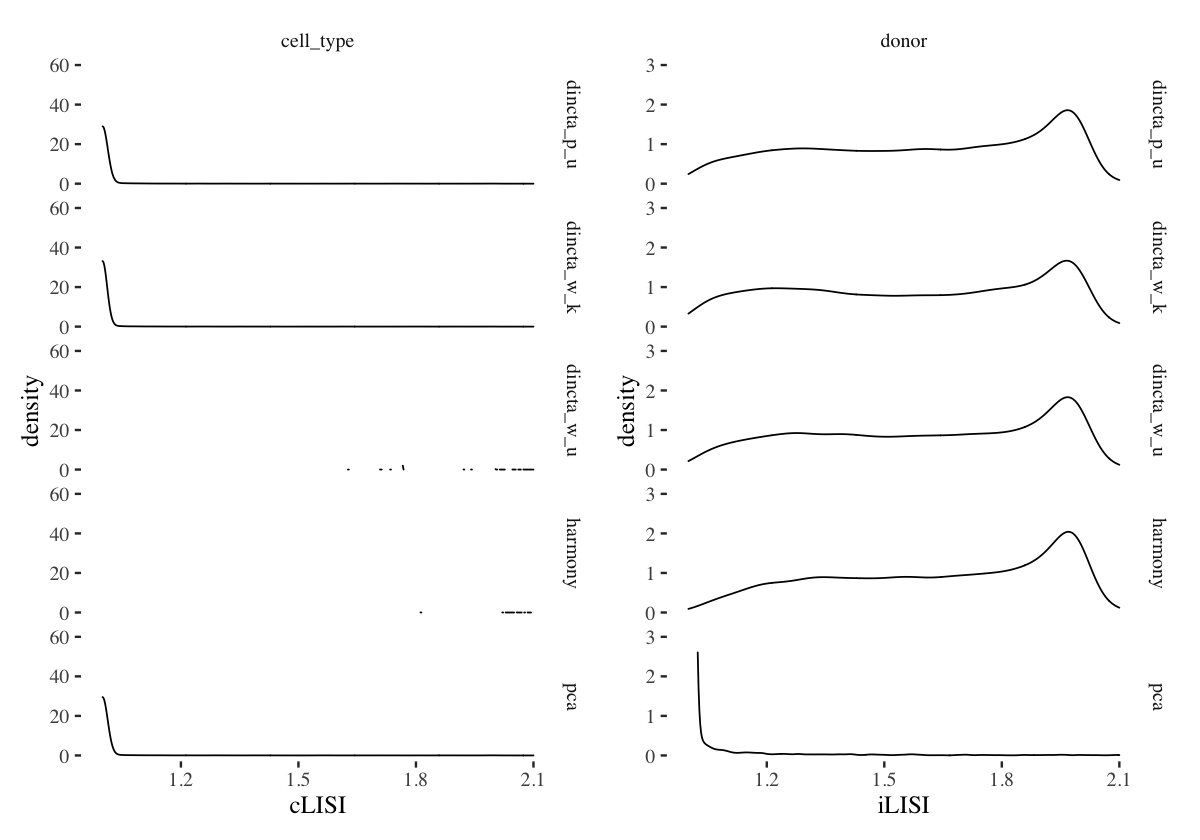

In [35]:
fig.size(7, 10)

pc = lisi_res %>% subset(key=="cell_type")%>% 
    ggplot(aes(val)) + 
        geom_density() + 
#facet_wrap(~type + key, scales = 'free') +
facet_grid(vars(type_new), vars(key), scales = 'free',space="free_y", margins = "vs")+
#  facet_grid(rows = vars(type))+
#facet_grid(cols = vars(key))+
#         facet_wrap(~type + key, scales = 'free') + 
        theme_tufte(base_size = 15) +
        xlim(1, 2.1) +
        ylim(0,60) +  labs(x = "cLISI")

pd = lisi_res %>% subset(key=="donor")%>% 
    ggplot(aes(val)) + 
        geom_density() + 
# facet_wrap(~type + key, scales = 'free') +
facet_grid(vars(type_new), vars(key), scales = 'free',
           space="free_y",
           margins = "vs"
          )+
#  facet_grid(rows = vars(type))+
#facet_grid(cols = vars(key))+
#         facet_wrap(~type + key, scales = 'free') + 
        theme_tufte(base_size = 15) +
        xlim(1, 2.1) +
        ylim(0,3) +  labs(x = "iLISI")
pc+ pd+guides(col = FALSE, fill = FALSE)
ggsave(path_join(output_path,'lisi_res.pdf'), device = "pdf",fonts=c("serif", "Palatino"),
       scale = 1, width = 10, height = 7, dpi = 600, limitsize = TRUE)
ggsave(path_join(output_path,'lisi_res.eps'), device = "eps",fonts=c("serif", "Palatino"),
       scale = 1, width = 10, height = 7, dpi = 600, limitsize = TRUE)

# Figures

In [36]:
colors_cell <- tableau_color_pal("Tableau 20")(length(union(meta_data$cell_subtype, meta_data$cell_type)))
names(colors_cell) <- union(meta_data$cell_subtype, meta_data$cell_type)
colors_donor <- toupper(c("#7fc97f", "#beaed4", "#fdc086"))
names(colors_donor) <- unique(meta_data$donor)
color_unknown =  c(`unknown`    = paste0("#", paste0(toupper(as.hexmode(c(129, 129, 129))), collapse = "")))
color_new_cell_type =c(`new_cell_type_1`    = paste0("#", paste0(toupper(as.hexmode(c(16, 0, 253))), collapse = "")),
                `new_cell_type_2`    = paste0("#", paste0(toupper(as.hexmode(c(16, 253, 0))), collapse = "")),
                `new_cell_type_3`    = paste0("#", paste0(toupper(as.hexmode(c(166, 0, 0))), collapse = "")),
                `new_cell_type_4`    = paste0("#", paste0(toupper(as.hexmode(c(166, 166, 0))), collapse = "")),
                `new_cell_type_5`    = paste0("#", paste0(toupper(as.hexmode(c(166, 0, 166))), collapse = "")),
                `new_cell_type_6`    = paste0("#", paste0(toupper(as.hexmode(c(0, 166, 166))), collapse = "")),
                `new_cell_type_7`    = paste0("#", paste0(toupper(as.hexmode(c(80, 0, 0))), collapse = "")),
                `new_cell_type_8`    = paste0("#", paste0(toupper(as.hexmode(c(0, 80, 0))), collapse = "")),
                `new_cell_type_9`    = paste0("#", paste0(toupper(as.hexmode(c(0, 0, 80))), collapse = "")),
                       `new_cell_type_10`    = paste0("#", paste0(toupper(as.hexmode(c(80, 80, 0))), collapse = "")),
                `new_cell_type_11`    = paste0("#", paste0(toupper(as.hexmode(c(0, 80, 80))), collapse = "")),
                `new_cell_type_12`    = paste0("#", paste0(toupper(as.hexmode(c(80, 0, 80))), collapse = "")),
            paste0("#", paste0(toupper(as.hexmode(c(180, 0, 180))), collapse = ""))
               )
colors_use <- c(colors_cell, colors_donor,color_unknown,color_new_cell_type)


In [37]:
colors_use 

mono14           cd4mem         cd4naive           cd8eff 
       "#4E79A7"        "#A0CBE8"        "#F28E2B"        "#FFBE7D" 
        cd8naive           cd8mem              adc           mono16 
       "#59A14F"        "#8CD17D"        "#B6992D"        "#F1CE63" 
              nk             treg                               hsc 
       "#499894"        "#86BCB6"        "#E15759"        "#FF9D9A" 
              mk              pdc             bmem           bnaive 
       "#79706E"        "#BAB0AC"        "#D37295"        "#FABFD2" 
            mono           tcells               dc           bcells 
       "#B07AA1"        "#D4A6C8"        "#9D7660"        "#D7B5A6" 
     threepfresh         threepv1        fivePrime          unknown 
       "#7FC97F"        "#BEAED4"        "#FDC086"        "#818181" 
 new_cell_type_1  new_cell_type_2  new_cell_type_3  new_cell_type_4 
       "#1000FD"        "#10FD00"        "#A60000"        "#A6A600" 
 new_cell_type_5  new_cell_type_6  new_cell_type_7  new_cell_type_8 
       "#A600A6"        "#00A6A6"        "#500000"        "#005000" 
 new_cell_type_9 new_cell_type_10 new_cell_type_11 new_cell_type_12 
       "#000050"        "#505000"        "#005050"        "#500050" 
                 
       "#B400B4"

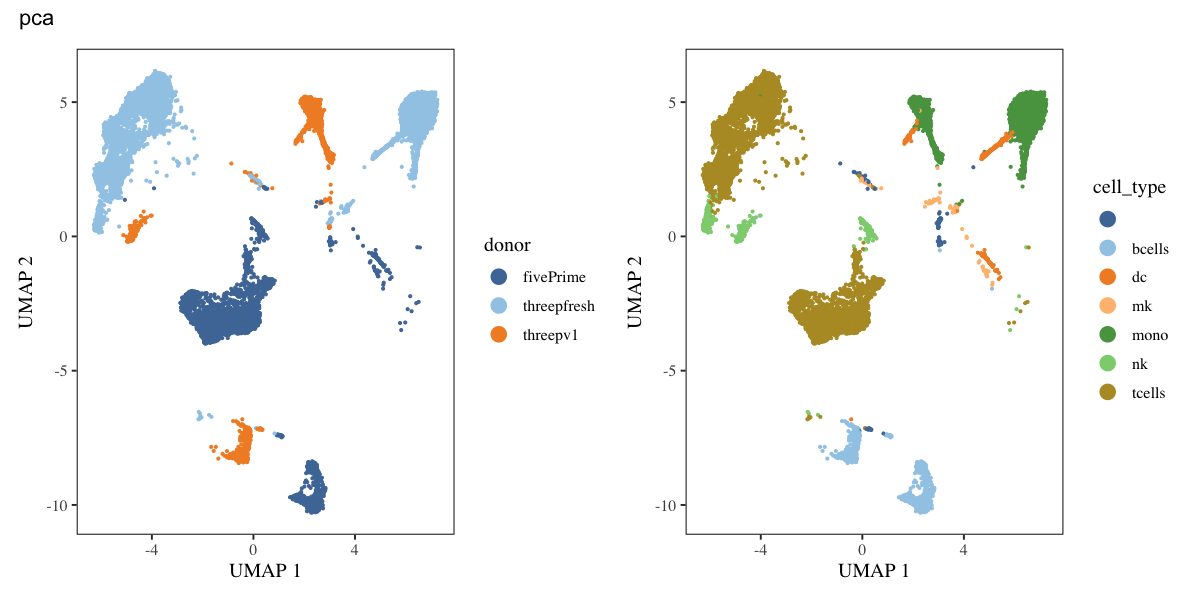

In [38]:
sca = 1
fig.size(5*sca, 10*sca)
do_scatter(pca_umap, meta_data, 'donor', palette_use = colors_use, 
           pt_shape = 21, pt_size = .2) + 
do_scatter(pca_umap, meta_data, 'cell_type', palette_use = colors_use,
           pt_shape = 21, pt_size = .2)+

plot_annotation(title = 'pca')
ggsave(path_join(output_path,'pca.eps'), device = "eps",fonts=c("serif", "Palatino"),
       scale = 1, width = 10*sca, height = 5*sca, dpi = 600, limitsize = TRUE)
ggsave(path_join(output_path,'pca.pdf'), device = "pdf",fonts=c("serif", "Palatino"),
       scale = 1, width = 10*sca, height = 5*sca, dpi = 600, limitsize = TRUE)

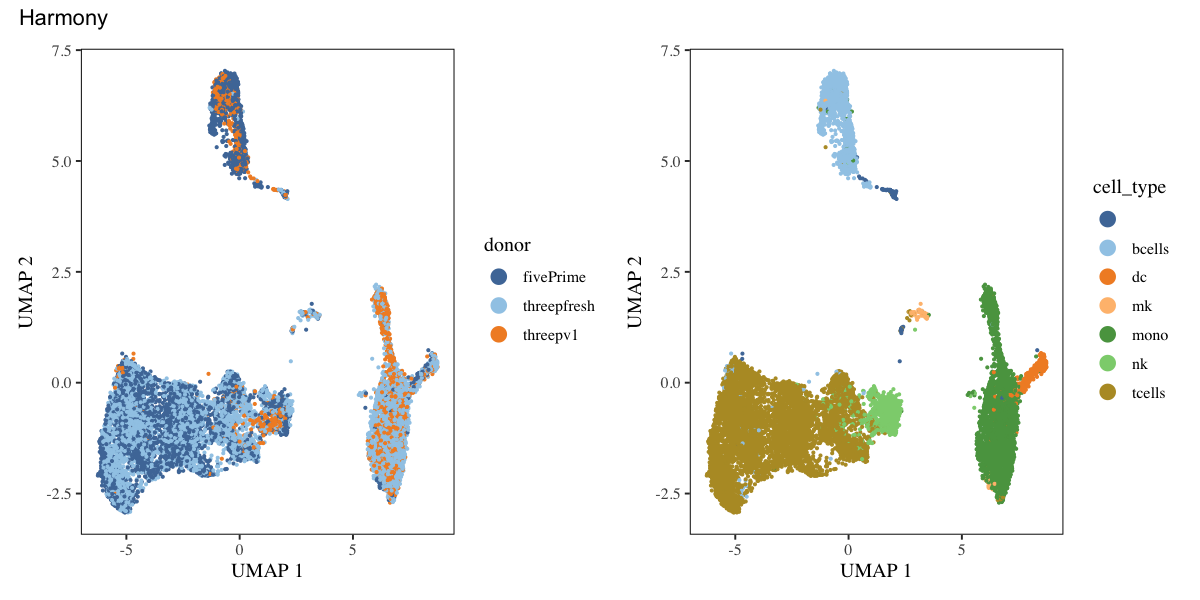

In [39]:
fig.size(5, 10)
do_scatter(harmony_umap, meta_data, 'donor', palette_use = colors_use, 
           pt_shape = 21, pt_size = .2) + 
do_scatter(harmony_umap, meta_data, 'cell_type', palette_use = colors_use,
           pt_shape = 21, pt_size = .2) + 
# do_scatter(harmony_umap, meta_data, 'cell_subtype', palette_use = colors_use,
#            pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'Harmony')
ggsave(path_join(output_path,'harmony.pdf'), device = "pdf",fonts=c("serif", "Palatino"),
       scale = 1, width = 10, height = 5, dpi = 600, limitsize = TRUE)
ggsave(path_join(output_path,'harmony.eps'), device = "eps",fonts=c("serif", "Palatino"),
       scale = 1, width = 10, height = 5, dpi = 600, limitsize = TRUE)

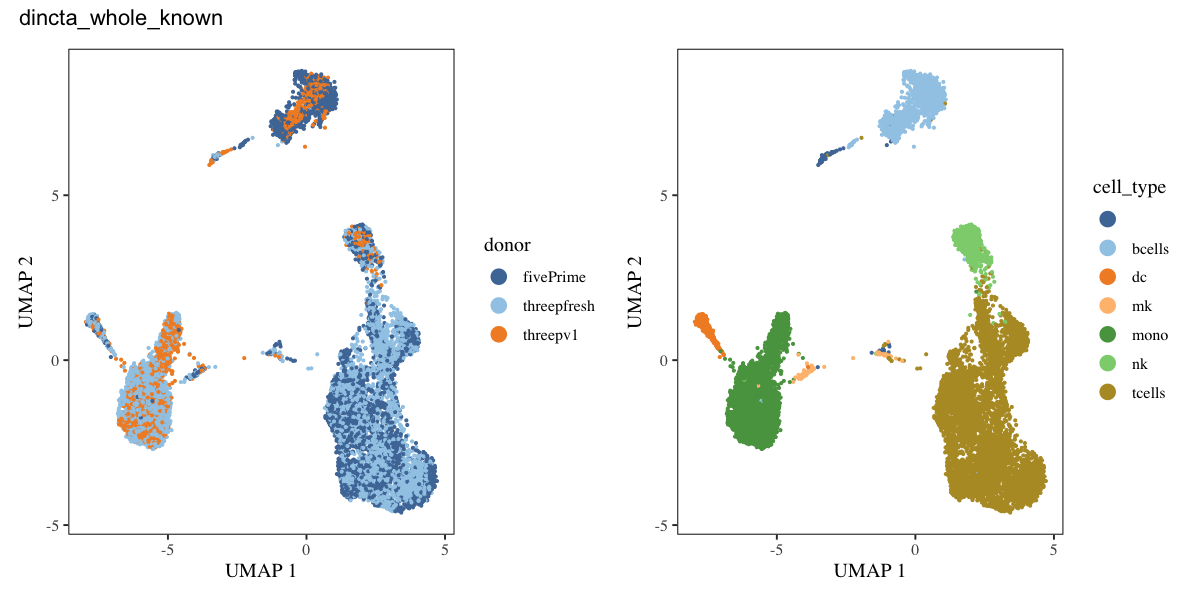

In [40]:
fig.size(5, 10)
do_scatter(dincta_whole_known_umap, meta_data, 'donor', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
do_scatter(dincta_whole_known_umap, meta_data, 'cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'dincta_whole_known')
ggsave(path_join(output_path,'dincta_whole_known.eps'), device = "eps",fonts=c("serif", "Palatino"),
       scale = 1, width = 10, height = 5, dpi = 600, limitsize = TRUE)
ggsave(path_join(output_path,'dincta_whole_known.pdf'), device = "pdf",fonts=c("serif", "Palatino"),
       scale = 1, width = 10, height = 5, dpi = 600, limitsize = TRUE)

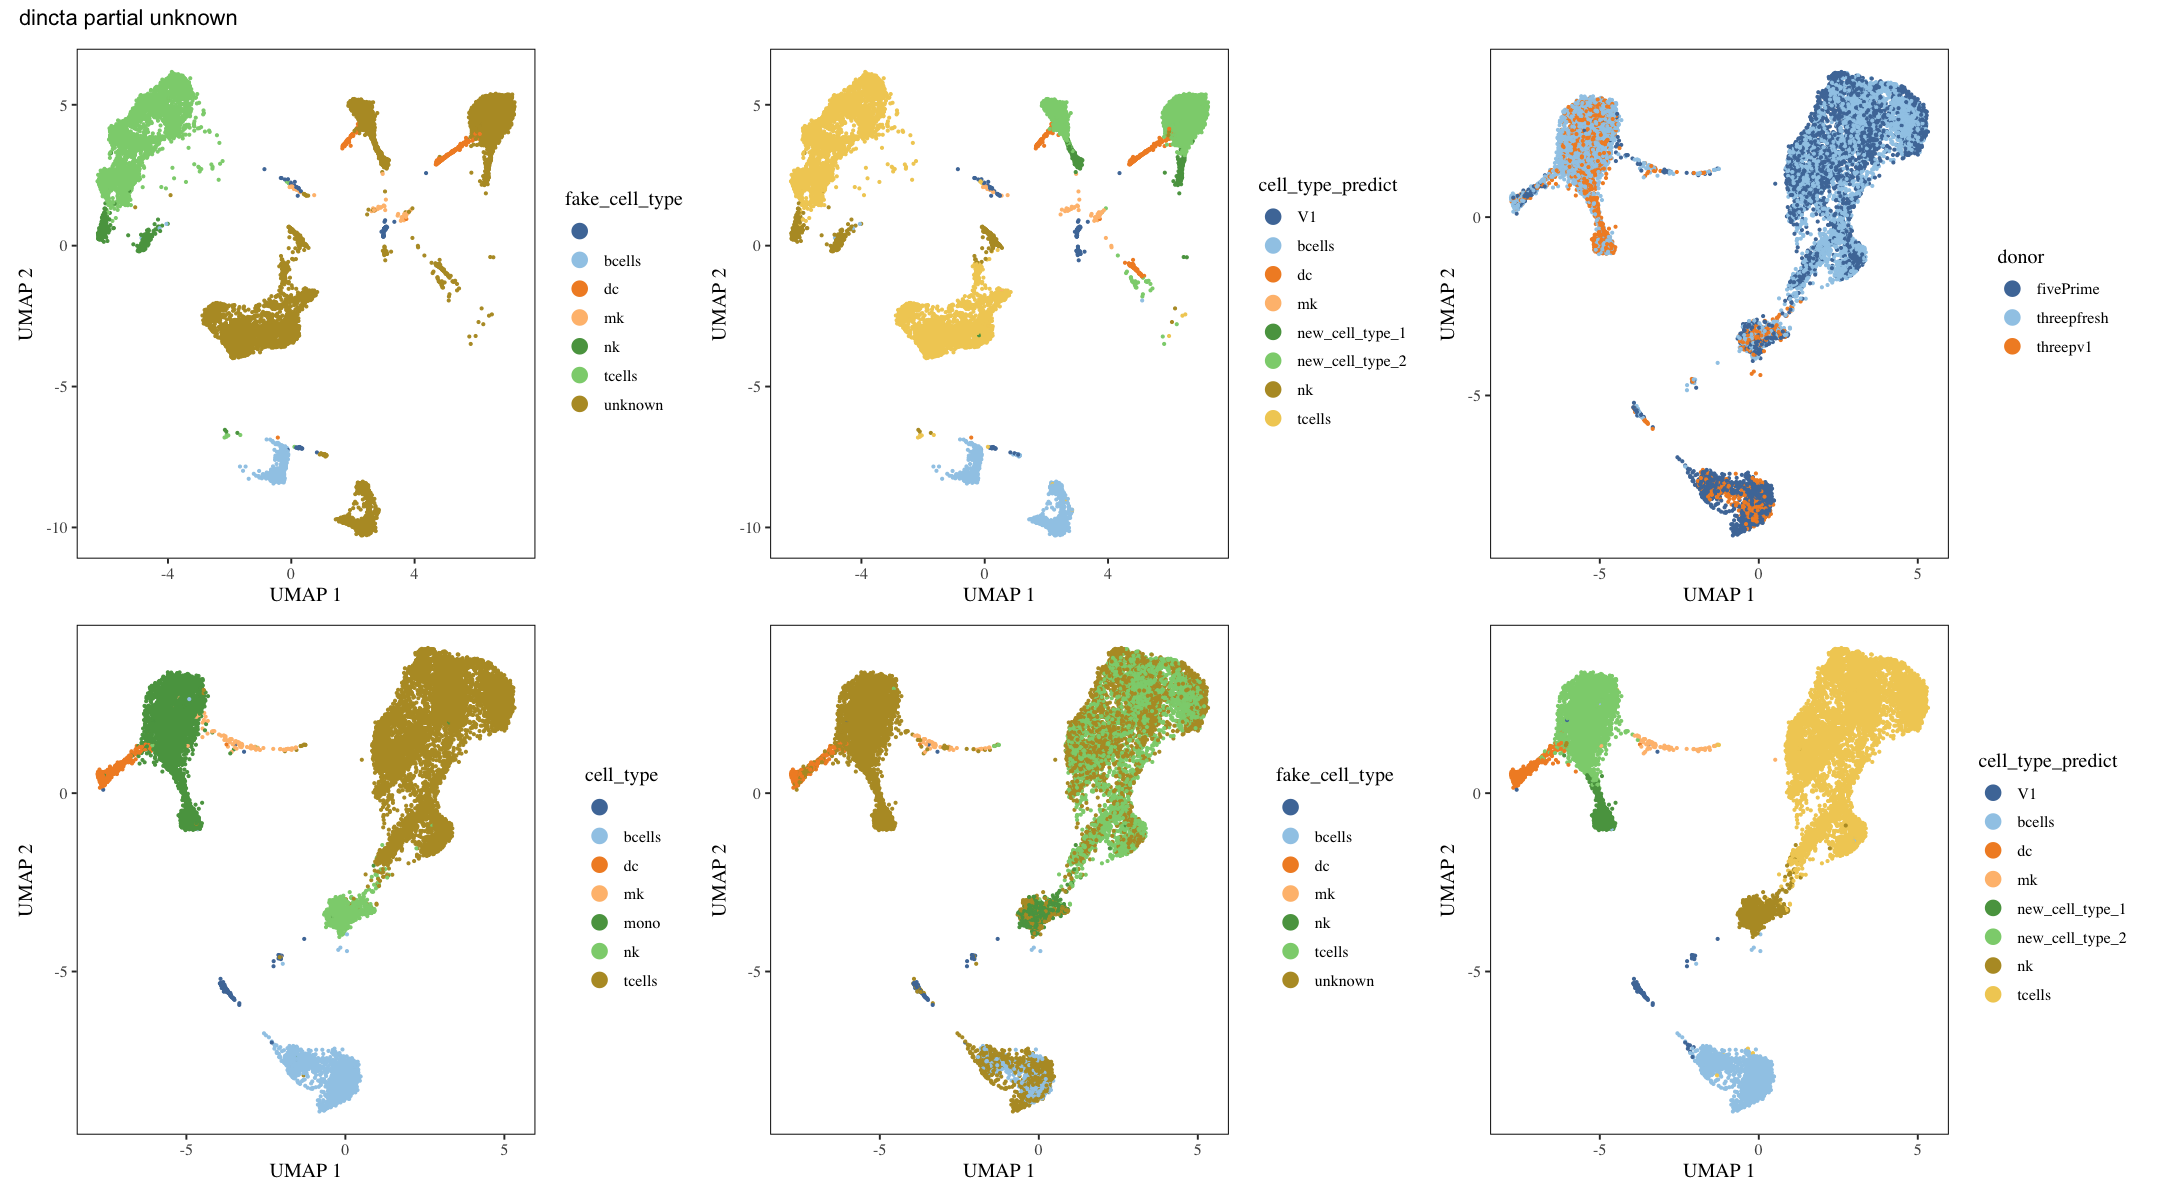

In [41]:
fig.size(10, 18)
do_scatter(pca_umap, dincta_partial_unknown_meta_data, 'fake_cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
do_scatter(pca_umap, dincta_partial_unknown_meta_data, 'cell_type_predict', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
do_scatter(dincta_partial_unknown_umap, dincta_partial_unknown_meta_data, 'donor', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
do_scatter(dincta_partial_unknown_umap, dincta_partial_unknown_meta_data, 'cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
do_scatter(dincta_partial_unknown_umap, dincta_partial_unknown_meta_data, 'fake_cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
do_scatter(dincta_partial_unknown_umap, dincta_partial_unknown_meta_data, 'cell_type_predict', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
plot_annotation(title = 'dincta partial unknown')
ggsave(path_join(output_path,'dincta_partial_unknown.eps'), device = "eps",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 10, dpi = 600, limitsize = T)
ggsave(path_join(output_path,'dincta_partial_unknown.pdf'), device = "pdf",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 10, dpi = 600, limitsize = T)

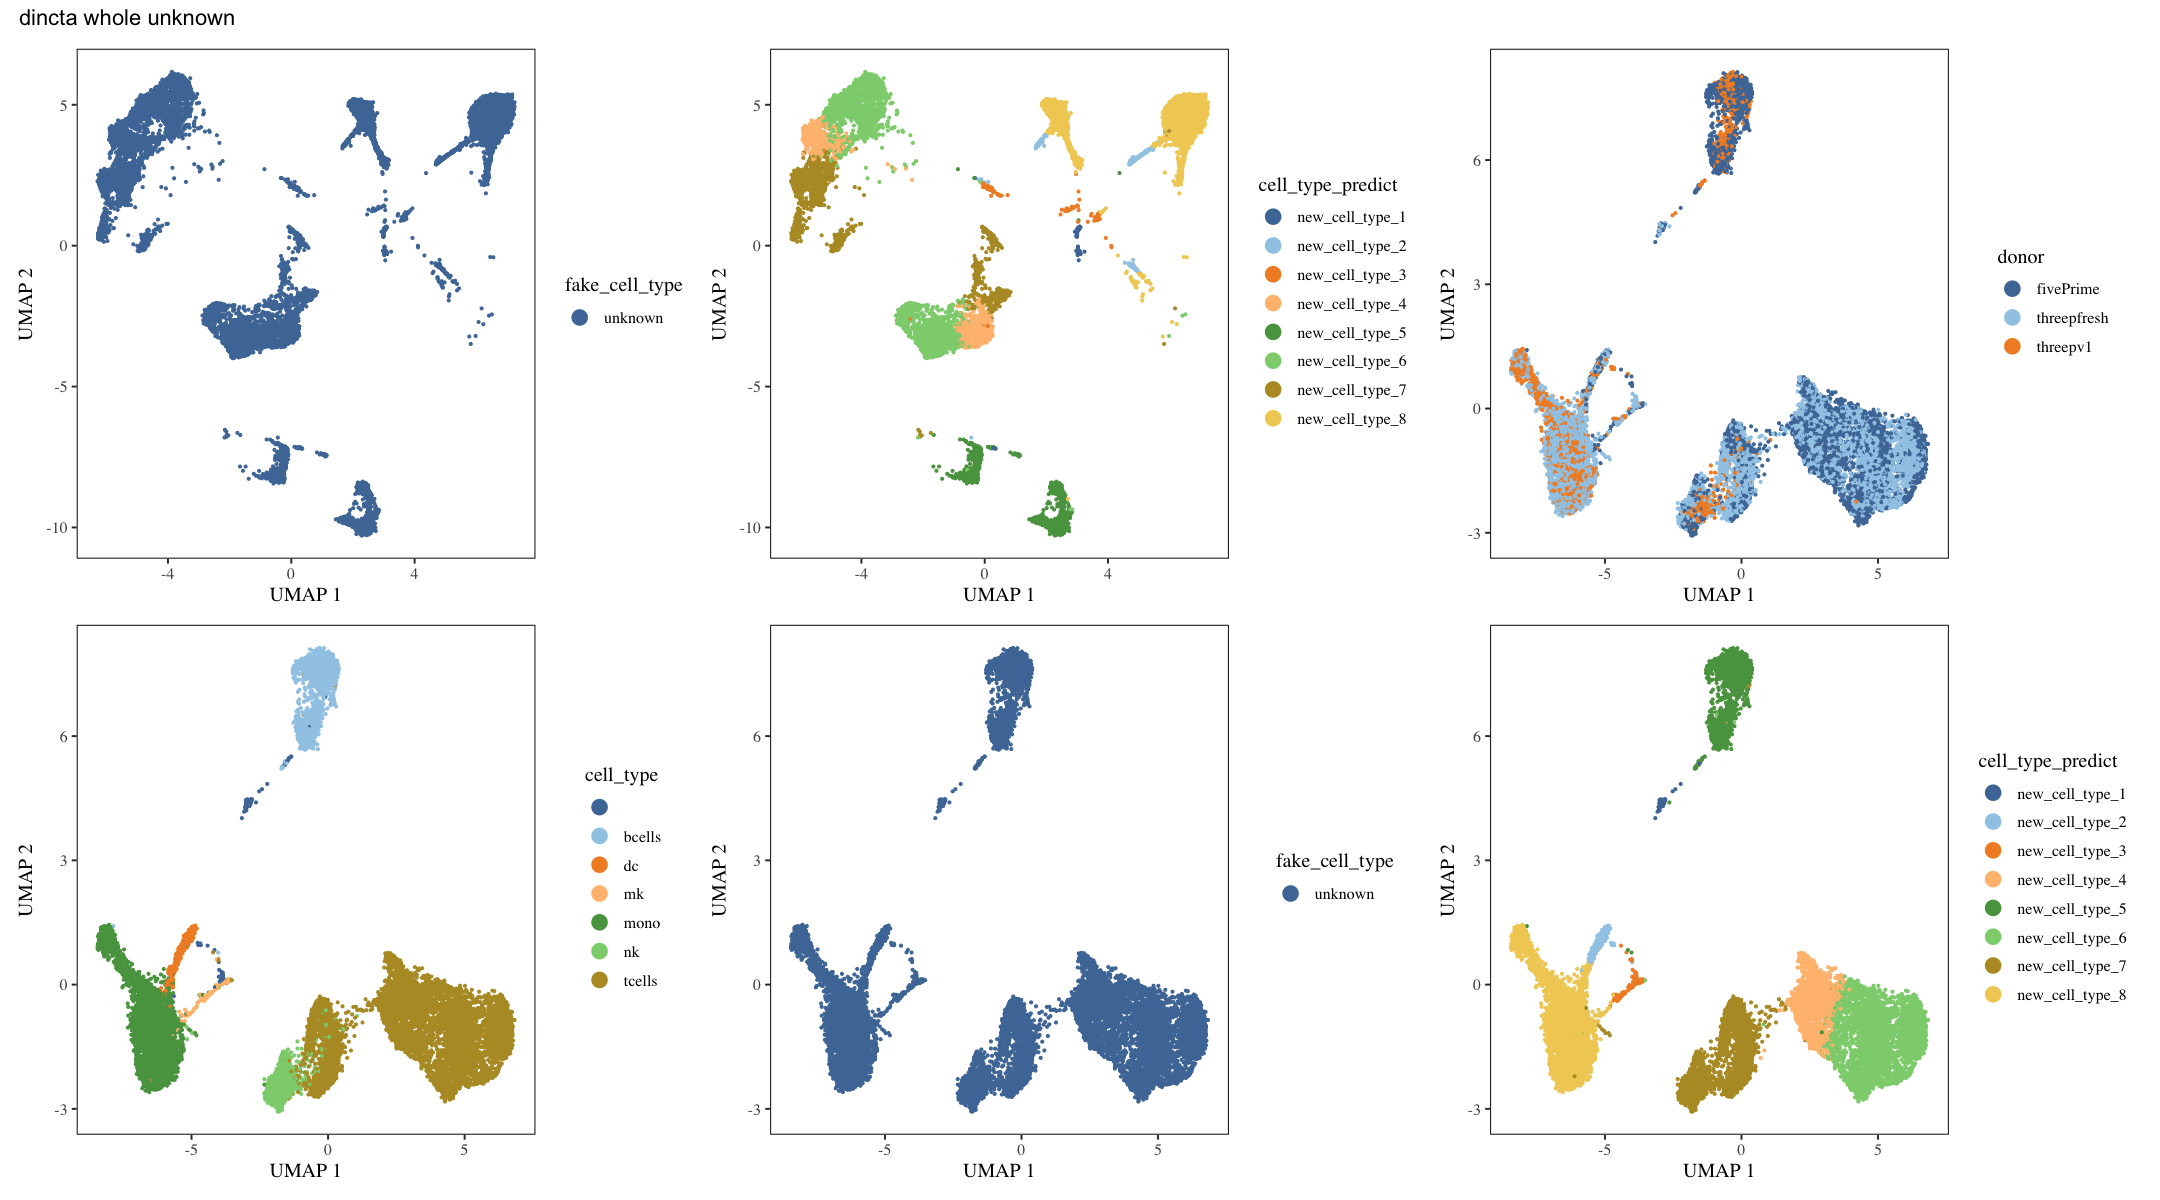

In [42]:
fig.size(10, 18)
do_scatter(pca_umap, dincta_whole_unknown_meta_data, 'fake_cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
do_scatter(pca_umap, dincta_whole_unknown_meta_data, 'cell_type_predict', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
do_scatter(dincta_whole_unknown_umap, dincta_whole_unknown_meta_data, 'donor', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
do_scatter(dincta_whole_unknown_umap, dincta_whole_unknown_meta_data, 'cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
do_scatter(dincta_whole_unknown_umap, dincta_whole_unknown_meta_data, 'fake_cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
do_scatter(dincta_whole_unknown_umap, dincta_whole_unknown_meta_data, 'cell_type_predict', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
plot_annotation(title = 'dincta whole unknown')
ggsave(path_join(output_path,'dincta_whole_unknown.eps'), device = "eps",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 10, dpi = 600, limitsize = T)
ggsave(path_join(output_path,'dincta_whole_unknown.pdf'), device = "pdf",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 10, dpi = 600, limitsize = T)


In [43]:
Phi_C = t(onehot(meta_data[['cell_type']]))
dim(Phi_C)
head(Phi_C)

[1]     7 14460

V1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
bcells,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,1,0,0,0
dc,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
mk,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
mono,1,0,0,1,1,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
nk,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [44]:
objs =list()
objs$harmony = harmony_obj
objs$dincta_whole_known = dincta_whole_known_obj
objs$dincta_partial_unknown = dincta_partial_unknown_obj
objs$dincta_whole_unknown = dincta_whole_unknown_obj

In [45]:
summary_entropy_error_table = summary_entropy_error(objs,Phi_C)
summary_entropy_error_table

type,fro_cluster_error_loss
<fct>,<dbl>
harmony,2140.21
dincta_whole_known,100.89
dincta_partial_unknown,629.72
dincta_whole_unknown,1668.74


In [46]:
summary_accuracy(objs,Phi_C)

type,accuracy,correct type,total number of cells
<fct>,<dbl>,<dbl>,<dbl>
harmony,0.96300,13925,14460
dincta_whole_known,0.99862,14440,14460
dincta_partial_unknown,0.98976,14312,14460
dincta_whole_unknown,0.96964,14021,14460


In [47]:
meta_data = dincta_partial_unknown_meta_data
Psi_C = dincta_partial_unknown_res$Phi_C
print("dincta_partial_unknown")
infer_accuracy_p_u = infer_accuracy(meta_data, Psi_C, Phi_C)
infer_accuracy_p_u

[1] "dincta_partial_unknown"
[1] "There is a tie for predict type  7  chose to map to  1"


[1] 9.5346e-01 1.3787e+04 1.4460e+04

In [48]:
meta_data = dincta_whole_unknown_meta_data
Psi_C = dincta_whole_unknown_res$Phi_C
print("dincta_whole_unknown")
infer_accuracy_w_u = infer_accuracy(meta_data, Psi_C, Phi_C)
infer_accuracy_w_u

[1] "dincta_whole_unknown"
[1] "There is a tie for predict type  1  chose to map to  7"


[1]     0.9121 13189.0000 14460.0000

In [49]:
infer_accuracy_R_summary(objs,Phi_C,0.92)

[1] "harmony : C is  7 C_ is  8"
[1] "dincta_whole_known : C is  7 C_ is  8"
[1] "dincta_partial_unknown : C is  7 C_ is  8"


,accuracy,number.of.correct.cells,number.of.total.cells
,<dbl>,<dbl>,<dbl>
harmony,0.89682,12968,14460
dincta_whole_known,0.99862,14440,14460
dincta_partial_unknown,0.96618,13971,14460
dincta_whole_unknown,0.92248,13339,14460


In [50]:
infer_accuracy_R_summary_table  = infer_accuracy_R_summary(objs,Phi_C,0.92,fix_C =T )
infer_accuracy_R_summary_table

,accuracy,number.of.correct.cells,number.of.total.cells
,<dbl>,<dbl>,<dbl>
harmony,0.89682,12968,14460
dincta_whole_known,0.99862,14440,14460
dincta_partial_unknown,0.90429,13076,14460
dincta_whole_unknown,0.92248,13339,14460


In [51]:
lisi_res_table 
summary_entropy_error_table
infer_accuracy_p_u 
infer_accuracy_w_u 
infer_accuracy_R_summary_table 

,cell_type mean,cell_type std,donor mean,donor std
dincta_whole_known,1.015,0.105,1.636,0.389
dincta_partial_unknown,1.017,0.104,1.664,0.376
dincta_whole_unknown,1.034,0.147,1.643,0.353
harmony,1.041,0.154,1.689,0.349
pca,1.017,0.112,1.015,0.110


type,fro_cluster_error_loss
<fct>,<dbl>
harmony,2140.21
dincta_whole_known,100.89
dincta_partial_unknown,629.72
dincta_whole_unknown,1668.74


[1] 9.5346e-01 1.3787e+04 1.4460e+04

[1]     0.9121 13189.0000 14460.0000

,accuracy,number.of.correct.cells,number.of.total.cells
,<dbl>,<dbl>,<dbl>
harmony,0.89682,12968,14460
dincta_whole_known,0.99862,14440,14460
dincta_partial_unknown,0.90429,13076,14460
dincta_whole_unknown,0.92248,13339,14460


In [52]:
save(lisi_res, meta_data, pca_embedding, pca_umap, 
harmony_embedding, harmony_umap,
dincta_whole_unknown_meta_data, dincta_whole_unknown_embedding, dincta_whole_unknown_umap,
dincta_partial_unknown_meta_data, dincta_whole_unknown_embedding, dincta_whole_unknown_umap,
 dincta_whole_known_embedding, dincta_whole_known_umap,
file=path_join(output_path, "output_data.RData"))
     
     
     


In [53]:
save(lisi_res_table,
summary_entropy_error_table,
infer_accuracy_p_u,
infer_accuracy_w_u,
infer_accuracy_R_summary_table,
     file=path_join(output_path, "output_table.RData"))

In [54]:
loss = get_loss(dincta_whole_unknown_obj)
loss$index = 1:length(loss$objective_kmeans)
names(loss)

[1] "objective_kmeans"                   "objective_kmeans_dist"             
[3] "objective_kmeans_entropy"           "objective_kmeans_cross"            
[5] "objective_kmeans_kl_cell_type_loss" "index"

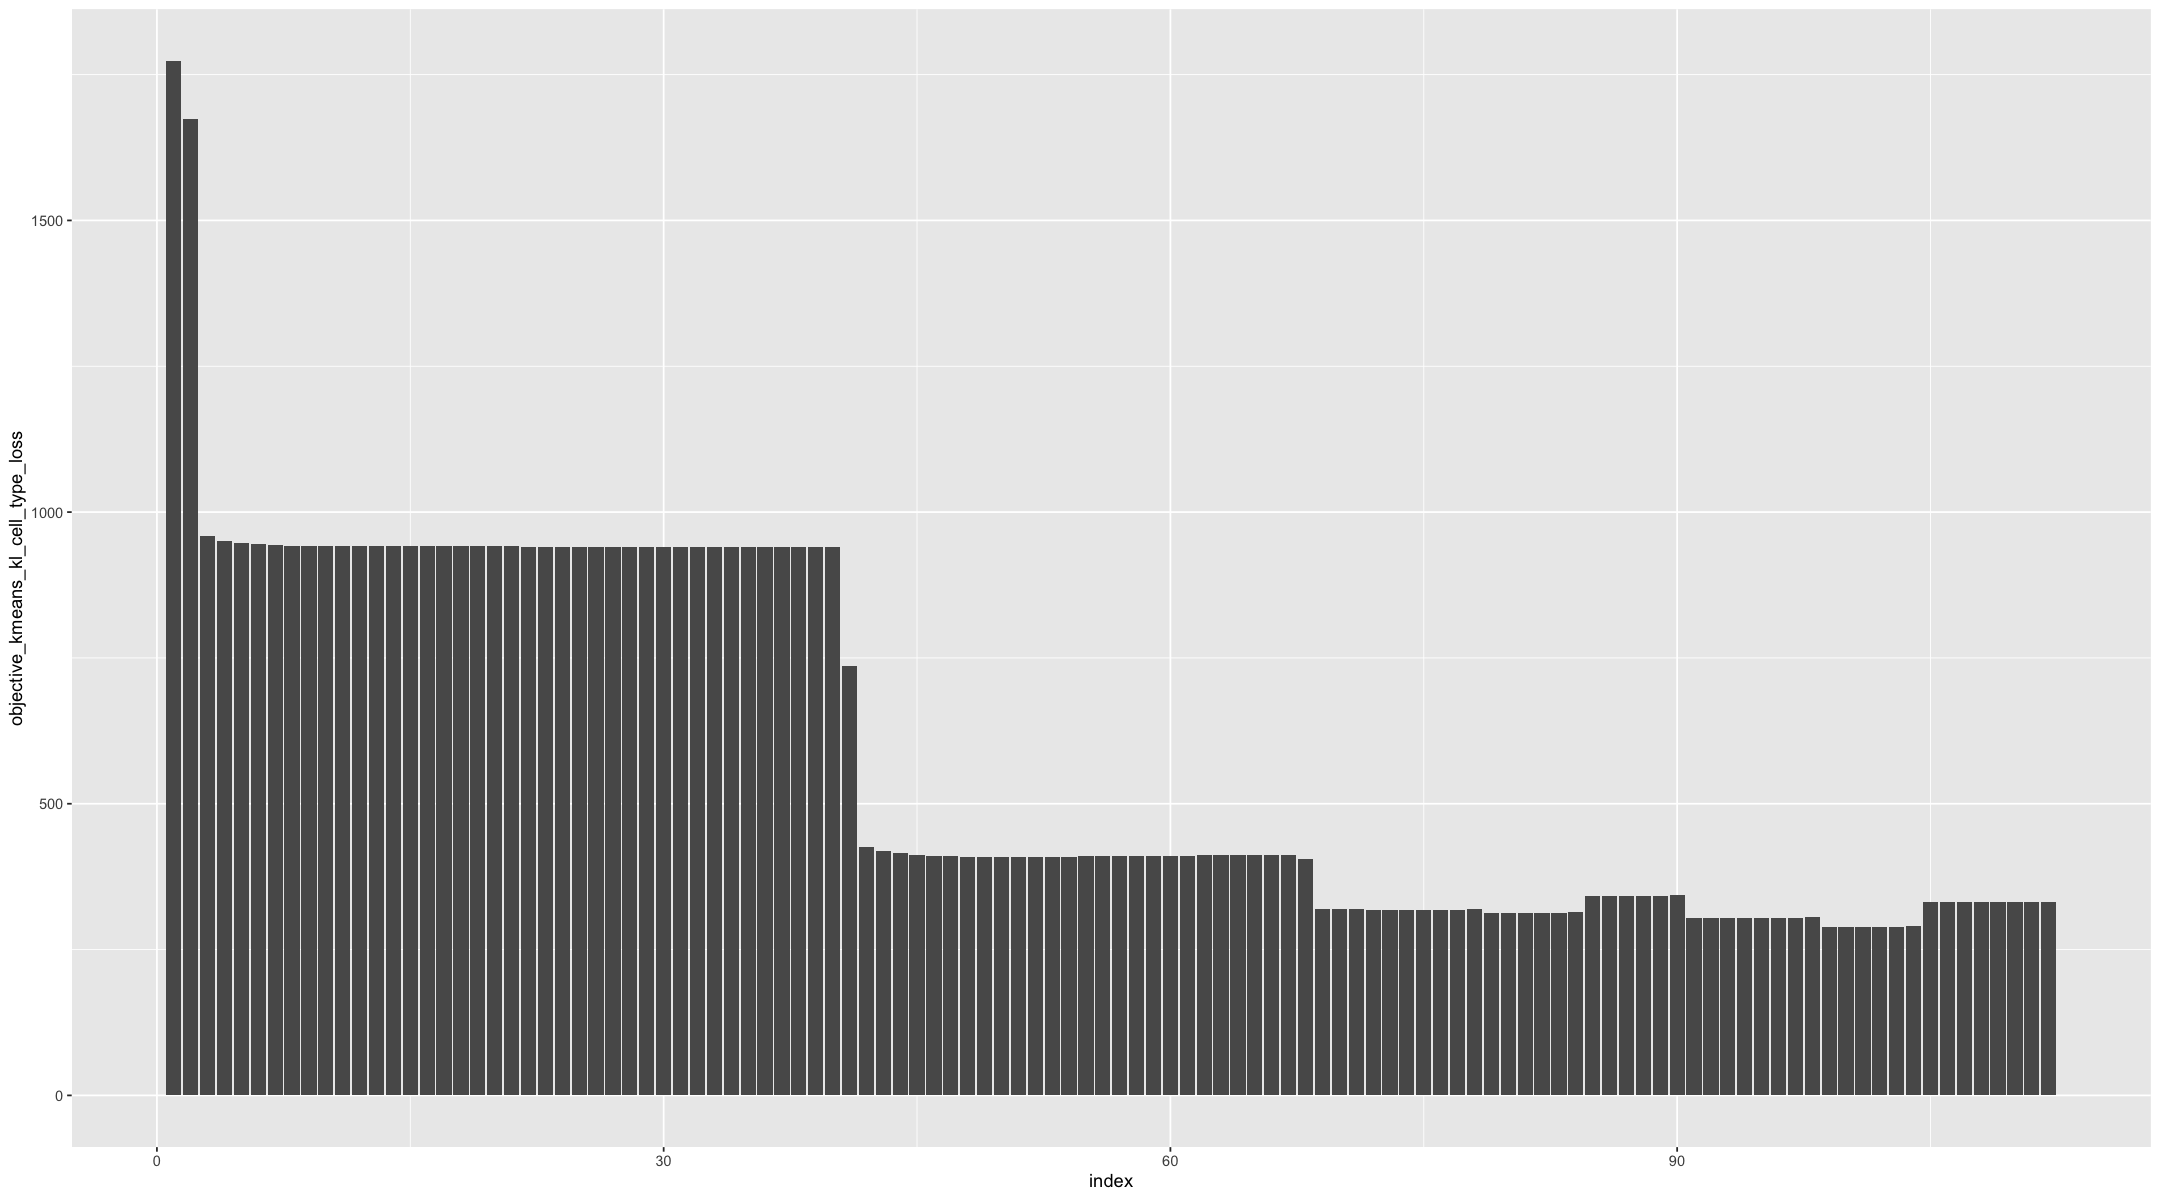

In [55]:
loss %>% ggplot(aes(x=index,y=objective_kmeans_kl_cell_type_loss)) + geom_col()

In [63]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Catalina 10.15.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] presto_1.0.0            lisi_1.0                ggrepel_0.8.2          
 [4] patchwork_1.0.1         ggthemes_4.2.0          singlecellmethods_0.1.0
 [7] dincta_0.1.0            harmony_0.99.9          Rcpp_1.0.5             
[10] forcats_0.5.0           stringr_1.4.0           dplyr_1.0.2            
[13] purrr_0.3.4             readr_1.3.1             tidyr_1.1.2            
[16] tibble_3.0.4            ggplot2_3.3.2           tidyverse_1.3.0        
[19] data.table_1.12.8      

loaded via a namespace (and not attached):
 [1] 